In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torchvision import transforms, models, utils

%matplotlib inline

pilTrans = transforms.ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [3]:
file_id = []
file_class = []
file_url = []

for file in glob.glob("data/dogvscat/*/*.jpg"):
    file_infos = file.split('\\')
    if file_infos[1] == 'test1':
        file_id.append(file_infos[2].split('.')[0])
        file_class.append(np.nan)
        file_url.append(file)
    else:
        train_infos = file_infos[2].split('.')
        file_id.append(train_infos[1])
        file_class.append(train_infos[0])
        file_url.append(file)
    
cat_dog_df = pd.DataFrame({'id':file_id, 'class':file_class, 'url': file_url})
train_df = cat_dog_df[~pd.isna(cat_dog_df['class'])]

test_df = cat_dog_df[pd.isna(cat_dog_df['class'])]
print('train:', len(train_df), 'test: ', len(test_df))
train_df['class'].value_counts()

train: 25000 test:  1569


dog    12500
cat    12500
Name: class, dtype: int64

In [4]:
train = train_df.sample(frac=0.9)
val = train_df[~train_df['id'].isin(train['id'])]
test = test_df
print('train: ',len(train), 'validation: ',len(val), 'test: ', len(test))

train:  22500 validation:  258 test:  1569


In [85]:
class DogVsCatDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        data1 = self.df.iloc[self.get_random_number()]
        data2 = self.df.iloc[self.get_random_number()]
        img1 = Image.open(data1['url'])
        img2 = Image.open(data2['url'])
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        if self.training:    
            #return 0 if same class, else return 1
            label = torch.from_numpy(np.array(int(data1['class']!=data2['class']),dtype=np.float32))
            return img1, img2, label
        else:
            return img1, img2
            
        
        

In [86]:
normalize = transforms.Normalize(
   mean=[0.5, 0.5, 0.5],
   std=[0.5, 0.5, 0.5]
)

ds_trans = transforms.Compose([
    transforms.Resize([230,230]),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),                           
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    normalize
])

test_trans = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    normalize
])

train_ds = DogVsCatDataset(train, transform=ds_trans)
val_ds = DogVsCatDataset(val, transform=ds_trans)
test_ds = DogVsCatDataset(test, transform=test_trans, training=False)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=6, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


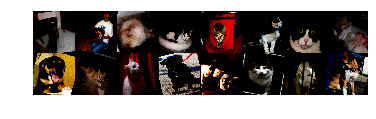

[1, 1, 0, 1, 0, 1, 1, 1]


In [90]:
# num_workers set to 0 in windows or else it will crash
vis_dataloader = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(utils.make_grid(concatenated))
print([int(i) for i in example_batch[2].numpy()])

In [91]:
# https://becominghuman.ai/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4
squeezynet = models.squeezenet1_1(pretrained=True)

in_ftrs = squeezynet.classifier[1].in_channels

squeezynet_features = list(squeezynet.classifier.children())
squeezynet_features[1] = nn.Conv2d(in_ftrs, 100, kernel_size=1,stride=1)
squeezynet.classifier = nn.Sequential(*squeezynet_features)
squeezynet.num_classes = 100

In [92]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.init_squeezynet()
        
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
     #       nn.Dropout(p=.2),
            
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
    #        nn.Dropout(p=.2),

            nn.Linear(500, 50)
        )
        
    def init_squeezynet(self):
        self.squeezynet = models.squeezenet1_1(pretrained=True)
        for param in self.squeezynet.parameters():
            param.requires_grad = False
        
        in_ftrs = squeezynet.classifier[1].in_channels
        squeezynet_features = list(squeezynet.classifier.children())
        squeezynet_features[1] = nn.Conv2d(in_ftrs, 500, kernel_size=1,stride=1)
        self.squeezynet.classifier = nn.Sequential(*squeezynet_features)
        self.squeezynet.num_classes = 500

    def forward_once(self, x):
        x = self.squeezynet(x)
        return self.fc(x)
        
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [93]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=10.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)

        loss_contrastive = torch.mean((1.0-label) * torch.pow(euclidean_distance, 2)/2 +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)/2)


        return loss_contrastive

In [94]:
class Solver(object):
    def __init__(self, model, data, config):
        self.model = model.to(device)
        self.data = data
        self.num_epochs = config.num_epochs
        self.lr = config.lr
        self.log_step = config.log_step
        self.current_epoch = 0
        self.best_loss = 99999
        self.save_model = False
        self.save_best_model = True
        self.save_dir = 'backup/'
        self.init_model()
        
    def init_model(self):
        self.criterion = ContrastiveLoss()
        self.optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()), lr = self.lr, momentum=0.9)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.5)
        
#     def to_variable(self, x):
#         """Convert tensor to variable."""
#         if torch.cuda.is_available():
#             x = x.cuda()
#         return Variable(x)
    
    def save_state(self, state, name):
        state = {
            'epoch': self.current_epoch,
            'optimizer': self.optimizer,
            'criterion': self.criterion,
            'scheduler': self.scheduler,
            'best_loss': self.best_loss
        }
        torch.save(state, self.save_dir+name+'.pth')
    
    def load_state(self, name):
        state = torch.load(self.save_dir+name+'.pth')
        print(state)
        self.current_epoch = state['epoch']
        self.optimizer = state['optimizer']
        self.criterion = state['criterion']
        self.scheduler = state['scheduler']
        self.best_loss = state['best_loss']
              
    def train(self):
        since = time.time()
        best_model_wts = self.model.state_dict()
        dataset_sizes = {'train': len(self.data['train'].dataset), 
                         'valid': len(self.data['valid'].dataset)}

        for epoch in range(self.current_epoch, self.num_epochs):
            self.current_epoch += 1
            for phase in ['train', 'valid']:
                if phase == 'train':
                    self.scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0

                for i, (imgs1, imgs2, labels) in enumerate(self.data[phase]):
                    imgs1, imgs2, labels = imgs1.to(device) , imgs2.to(device), labels.to(device)

                    self.optimizer.zero_grad()
                    output1,output2 = self.model(imgs1,imgs2)

                    loss_contrastive = self.criterion(output1,output2,labels)
#                     print(loss_contrastive.item())

                    if phase == 'train':
                        loss_contrastive.backward()
                        self.optimizer.step()
                        
                        if (i+1) % self.log_step == 0:
                            print('Epoch [%d/%d], Steps [%d/%d], train loss: %.4f'
                                 %(epoch+1, self.num_epochs, i+1, len(self.data[phase]), loss_contrastive.item()))
    
                    running_loss += loss_contrastive.item()

                if phase == 'train':
                    train_epoch_loss = running_loss / len(self.data[phase])
                else:
                    valid_epoch_loss = running_loss / len(self.data[phase])

                if phase == 'valid' and valid_epoch_loss < self.best_loss:
                    self.best_loss = valid_epoch_loss
                    best_model_wts = self.model.state_dict()
                    
                    self.save_state({
                        'state_dict': best_model_wts
                    },'best')
                    

            print('Epoch [{}/{}] train loss: {:.4f} ' 
                  'valid loss: {:.4f}'.format(
                    epoch + 1, self.num_epochs,
                    train_epoch_loss, 
                    valid_epoch_loss))

        print('Best val Loss: {:4f}'.format(self.best_loss))

        self.model.load_state_dict(best_model_wts)
                
#load model
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])

In [95]:
class Config():
    num_epochs = 100
    lr = 0.01
    log_step = 100

In [96]:
net = SiameseNetwork()
data = {'train':train_dl, 'valid':val_dl}
config = Config()
solver = Solver(net,data,config)

In [97]:
solver.train()

Epoch [1/100], Steps [100/352], train loss: 7.6275
Epoch [1/100], Steps [200/352], train loss: 9.1422
Epoch [1/100], Steps [300/352], train loss: 5.3795
Epoch [1/100] train loss: 7.3092 valid loss: 11.4007
Epoch [2/100], Steps [100/352], train loss: 8.7444
Epoch [2/100], Steps [200/352], train loss: 5.3648
Epoch [2/100], Steps [300/352], train loss: 6.3615
Epoch [2/100] train loss: 5.4308 valid loss: 7.2669
Epoch [3/100], Steps [100/352], train loss: 3.5370
Epoch [3/100], Steps [200/352], train loss: 5.2774
Epoch [3/100], Steps [300/352], train loss: 4.4462
Epoch [3/100] train loss: 4.6178 valid loss: 7.3277
Epoch [4/100], Steps [100/352], train loss: 3.8470
Epoch [4/100], Steps [200/352], train loss: 5.0193
Epoch [4/100], Steps [300/352], train loss: 6.1378
Epoch [4/100] train loss: 4.4284 valid loss: 5.4886
Epoch [5/100], Steps [100/352], train loss: 2.8977
Epoch [5/100], Steps [200/352], train loss: 3.1000
Epoch [5/100], Steps [300/352], train loss: 4.4540
Epoch [5/100] train loss: 

Epoch [40/100], Steps [300/352], train loss: 1.8763
Epoch [40/100] train loss: 2.6177 valid loss: 6.2133
Epoch [41/100], Steps [100/352], train loss: 4.6964
Epoch [41/100], Steps [200/352], train loss: 1.8153
Epoch [41/100], Steps [300/352], train loss: 3.3092
Epoch [41/100] train loss: 2.8047 valid loss: 6.6959
Epoch [42/100], Steps [100/352], train loss: 4.3418
Epoch [42/100], Steps [200/352], train loss: 1.1466
Epoch [42/100], Steps [300/352], train loss: 3.0492
Epoch [42/100] train loss: 2.8039 valid loss: 12.3153
Epoch [43/100], Steps [100/352], train loss: 3.8341
Epoch [43/100], Steps [200/352], train loss: 1.1741
Epoch [43/100], Steps [300/352], train loss: 1.9973
Epoch [43/100] train loss: 2.8006 valid loss: 6.1745
Epoch [44/100], Steps [100/352], train loss: 1.5457
Epoch [44/100], Steps [200/352], train loss: 3.1804
Epoch [44/100], Steps [300/352], train loss: 2.9005
Epoch [44/100] train loss: 2.6762 valid loss: 7.2599
Epoch [45/100], Steps [100/352], train loss: 1.3893
Epoch 

KeyboardInterrupt: 

In [155]:
# solver.load_state('best')

{'epoch': 0, 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.001
    lr: 0.000125
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'criterion': ContrastiveLoss(), 'scheduler': <torch.optim.lr_scheduler.StepLR object at 0x0000014D6BD95588>, 'best_loss': 4.974965572357178}


In [114]:
def denormalize(img):
    return img / 2 + 0.5

def visualize(dataloader, model):
    data = iter(dataloader).next()
    if len(data) == 3:
        img1, img2, lab = data
    else:
        img1, img2 = data
        
    with torch.no_grad():
        img1 = img1.to(device)
        img2 = img2.to(device)

        img1_embedding, img2_embedding = model(img1,img2)

        res = F.pairwise_distance(img1_embedding, img2_embedding)
        res = np.asarray(res.data.cpu())

    img_dict_list = []
    n_img = 6
    for i in range(n_img): 
        img_dict_list.append((np.asarray(pilTrans(denormalize(img1[i].cpu()))), np.asarray(pilTrans(denormalize(img2[i].cpu()))), res[i]))

    fig, m_axs = plt.subplots(2, n_img, figsize = (20, 5))
    for (img1, img2, res), (c_img1, c_img2) in zip(img_dict_list, m_axs.T):
        c_img1.imshow(img1)
        c_img1.axis('off')

        c_img2.imshow(img2)
        c_img2.axis('off')
        c_img2.set_title(res)

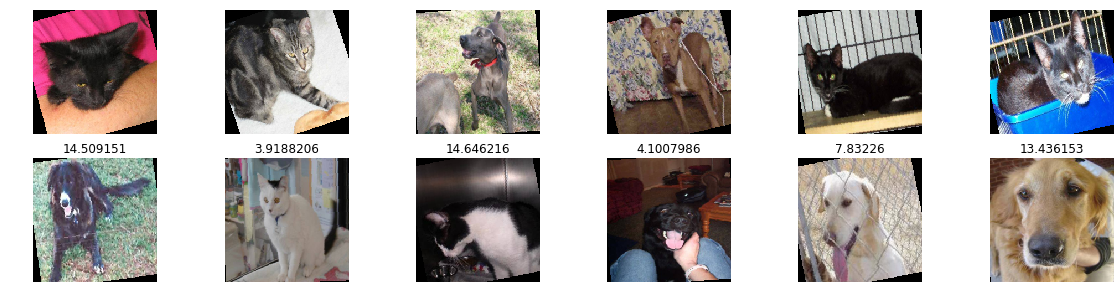

In [115]:
visualize(train_dl, net)

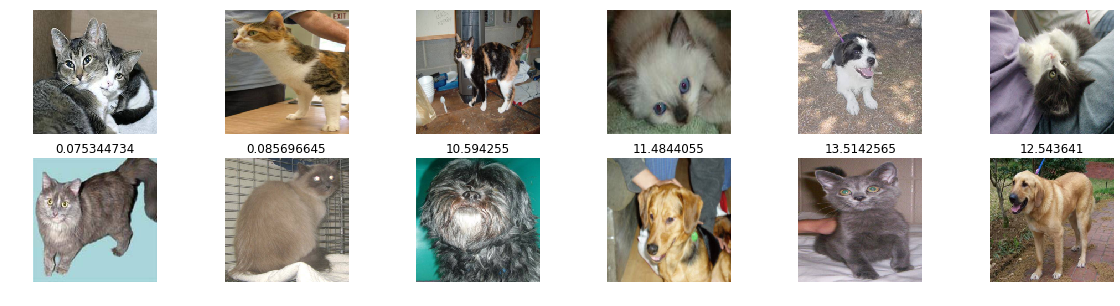

In [120]:
visualize(test_dl, net)